В этом ноутбуке продемонстрирован весь пайплайн работы симулятора на датасете MovieLens 20M: генерация эмбеддингов профилей пользователей, обучение моделей генерации синтетических профилей пользователей, обучение функции отклика, обучение рекомендательной системы UCB путем взаимодействия с симулятором.

In [1]:
import os

import pandas as pd
import numpy as np

import time

from pyspark import SparkConf
from pyspark.sql import SparkSession
from pyspark.ml.feature import VectorAssembler, PCA
from pyspark.ml.functions import vector_to_array
from pyspark.sql.functions import col, lit
import pyspark.sql.functions as sf
from pyspark.ml.classification import LogisticRegression, RandomForestClassifier, FMClassifier
from pyspark.ml import Pipeline, PipelineModel
from pyspark.sql import types as st

from replay.session_handler import State
from replay.data_preparator import Indexer
from replay.models import RandomRec
from replay.metrics import NDCG, Precision, RocAuc

from sim4rec.utils import pandas_to_spark, VectorElementExtractor
from sim4rec.modules import RealDataGenerator, SDVDataGenerator, CrossJoinItemEstimator
from sim4rec.modules import evaluate_synthetic, EvaluateMetrics
from sim4rec.response import ParametricResponseFunction, BernoulliResponse

from transformers import ModelCalibration

from replay.models import UCB

%matplotlib inline
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings("ignore")

spark = SparkSession.builder\
    .appName('simulator_movielens')\
    .master('local[8]')\
    .config('spark.sql.shuffle.partitions', '8')\
    .config('spark.default.parallelism', '8')\
    .config('spark.driver.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.executor.extraJavaOptions', '-XX:+UseG1GC')\
    .config('spark.sql.autoBroadcastJoinThreshold', '-1')\
    .config('spark.driver.memory', '128g')\
    .config('spark.local.dir', './tmp')\
    .getOrCreate()

State(spark)

/data/home/estavinova/.conda/envs/sim-exp/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
22/11/14 14:21:59 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable
Using Spark's default log4j profile: org/apache/spark/log4j-defaults.properties
Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
22/11/14 14:22:00 WARN SparkConf: Note that spark.local.dir will be overridden by the value set by the cluster manager (via SPARK_LOCAL_DIRS in mesos/standalone/kubernetes and LOCAL_DIRS in YARN).
22/11/14 14:22:01 WARN Utils: Service 'SparkUI' could not bind on port 4040. Attempting port 4041.


In [4]:
DATA_PATH = r'file:///data/home/estavinova/DL_0/real_data_simulator/Movielens/'

Работаем с предобработанными данными, которые разделены на три части по времени выставления рейтинга. Оценки 1 и 2 считаем отрицательными (0); 3, 4 и 5 -- положительными (1).

Данные были предварительно предобработаны (код в папке Movielens): составлены профили польззователей и предложений по истории откликов, а также данные разделены по времени выставления оценок на обучающую, валидационную и тестовую выборки.

In [5]:
import pyspark.sql.types as st

USER_PREFIX = 'user_'
ITEM_PREFIX = 'item_'

USER_SCHEMA = st.StructType(
    [st.StructField('user_idx', st.IntegerType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
ITEM_SCHEMA = st.StructType(
    [st.StructField('item_idx', st.IntegerType())] +\
    [st.StructField('year', st.IntegerType())] +\
    [st.StructField('rating_avg', st.DoubleType())] +\
    [st.StructField(f'genre{i}', st.DoubleType()) for i in range(19)] +\
    [st.StructField(f'w2v_{i}', st.DoubleType()) for i in range(300)]
)
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

users_df_train = spark.read.csv(DATA_PATH+'train/users.csv', header=True, schema=USER_SCHEMA)
items_df_train = spark.read.csv(DATA_PATH+'train/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_train   = spark.read.csv(DATA_PATH+'train/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_train = users_df_train.withColumnRenamed("user_idx", "user_id")
items_df_train = items_df_train.withColumnRenamed("item_idx", "item_id")
log_df_train = log_df_train.withColumnRenamed("user_idx", "user_id")
log_df_train = log_df_train.withColumnRenamed("item_idx", "item_id")

log_df_train = log_df_train.join(users_df_train, log_df_train['user_id'] == users_df_train['user_id'], 'leftsemi')
log_df_train = log_df_train.join(items_df_train, log_df_train['item_id'] == items_df_train['item_id'], 'leftsemi')

for c in users_df_train.columns[1:]:
    users_df_train = users_df_train.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_train.columns[1:]:
    items_df_train = items_df_train.withColumnRenamed(c, 'item_' + c)

log_df_train = log_df_train.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_train = users_df_train.cache()
items_df_train = items_df_train.cache()
log_df_train = log_df_train.cache()

users_df_train.count()
items_df_train.count()
log_df_train.count()

22/11/14 14:24:39 WARN package: Truncated the string representation of a plan since it was too large. This behavior can be adjusted by setting 'spark.sql.debug.maxToStringFields'.


10000132

In [6]:
users_df_val = spark.read.csv(DATA_PATH+'val/users.csv', header=True, schema=USER_SCHEMA)
items_df_val = spark.read.csv(DATA_PATH+'val/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_val   = spark.read.csv(DATA_PATH+'val/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_val = users_df_val.withColumnRenamed("user_idx", "user_id")
items_df_val = items_df_val.withColumnRenamed("item_idx", "item_id")
log_df_val = log_df_val.withColumnRenamed("user_idx", "user_id")
log_df_val = log_df_val.withColumnRenamed("item_idx", "item_id")

log_df_val = log_df_val.join(users_df_val, log_df_val['user_id'] == users_df_val['user_id'], 'leftsemi')
log_df_val = log_df_val.join(items_df_val, log_df_val['item_id'] == items_df_val['item_id'], 'leftsemi')

for c in users_df_val.columns[1:]:
    users_df_val = users_df_val.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_val.columns[1:]:
    items_df_val = items_df_val.withColumnRenamed(c, 'item_' + c)

log_df_val = log_df_val.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

users_df_val = users_df_val.cache()
items_df_val = items_df_val.cache()
log_df_val = log_df_val.cache()

users_df_val.count()
items_df_val.count()
log_df_val.count()

5000065

In [7]:
users_df_test = spark.read.csv(DATA_PATH+'test/users.csv', header=True, schema=USER_SCHEMA)
items_df_test = spark.read.csv(DATA_PATH+'test/items.csv', header=True, schema=ITEM_SCHEMA)
log_df_test   = spark.read.csv(DATA_PATH+'test/rating.csv', header=True, schema=LOG_SCHEMA)

users_df_test = users_df_test.withColumnRenamed("user_idx", "user_id")
items_df_test = items_df_test.withColumnRenamed("item_idx", "item_id")
log_df_test = log_df_test.withColumnRenamed("user_idx", "user_id")
log_df_test = log_df_test.withColumnRenamed("item_idx", "item_id")

log_df_test = log_df_test.join(users_df_test, log_df_test['user_id'] == users_df_test['user_id'], 'leftsemi')
log_df_test = log_df_test.join(items_df_test, log_df_test['item_id'] == items_df_test['item_id'], 'leftsemi')

for c in users_df_test.columns[1:]:
    users_df_test = users_df_test.withColumnRenamed(c, 'user_' + c)
    
for c in items_df_test.columns[1:]:
    items_df_test = items_df_test.withColumnRenamed(c, 'item_' + c)

log_df_test = log_df_test.withColumn(
    'relevance', sf.when(sf.col('relevance') >= 3, 1).otherwise(0))

items_df_test = items_df_test.na.drop()

users_df_test = users_df_test.cache()
items_df_test = items_df_test.cache()
log_df_test = log_df_test.cache()

users_df_test.count()
items_df_test.count()
log_df_test.count()

5000066

# Генерация эмбеддингов

В результате экспериментального исследования методов генерации эмбеддингов (movielens_embeddings.ipynb) было решено использовать метод главных компонент в случае датасета MovieLens. Далее с помощью этого метода генерируются профили пользователей.

In [8]:
%%time
va = VectorAssembler(
    inputCols=users_df_train.columns[1:],
    outputCol='features'
)
pca = PCA(k=9, inputCol="features")
pca.setOutputCol("pca_features")
model = pca.fit(va.transform(users_df_train))
model.explainedVariance

22/11/14 14:27:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeSystemBLAS
22/11/14 14:27:23 WARN BLAS: Failed to load implementation from: com.github.fommil.netlib.NativeRefBLAS
22/11/14 14:27:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeSystemLAPACK
22/11/14 14:27:25 WARN LAPACK: Failed to load implementation from: com.github.fommil.netlib.NativeRefLAPACK


CPU times: user 55.3 ms, sys: 19.1 ms, total: 74.4 ms
Wall time: 7.61 s


DenseVector([0.5139, 0.1649, 0.0891, 0.0435, 0.0366, 0.0279, 0.0189, 0.0136, 0.0108])

In [9]:
%%time
pca_users = model.transform(va.transform(users_df_train)).select(['user_id', 'pca_features'])

pca_users = (pca_users.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users.toPandas()

CPU times: user 658 ms, sys: 82.5 ms, total: 740 ms
Wall time: 3.37 s


,user_id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.622775,-0.577107,-0.162202,-0.176447,-0.253122,-0.116941,0.235773,0.264329,0.292615
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
80645,138483,-3.147429,-0.098111,-0.024827,-0.378338,0.148554,0.112192,0.027015,0.193308,-0.003480
80646,138484,-3.287778,-0.394522,-0.021202,-0.499686,0.129370,0.085624,0.015235,0.210864,0.017104
80647,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
80648,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154


In [10]:
%%time
pca_users_val = model.transform(va.transform(users_df_val)).select(['user_id', 'pca_features'])

pca_users_val = (pca_users_val.withColumn('user_feature', vector_to_array('pca_features'))).select(['user_id'] + [col('user_feature')[i] for i in range(9)])
pca_users_val.toPandas()

CPU times: user 888 ms, sys: 72.3 ms, total: 960 ms
Wall time: 3.13 s


,user_id,user_feature[0],user_feature[1],user_feature[2],user_feature[3],user_feature[4],user_feature[5],user_feature[6],user_feature[7],user_feature[8]
0,1,-3.703400,-0.645062,-0.321042,-0.159401,0.019337,-0.036376,0.057187,0.215621,0.185469
1,2,-3.961731,-0.617859,-0.131752,-0.185460,-0.139910,0.105091,0.191646,0.156198,0.059740
2,3,-4.084716,-0.625386,-0.236358,-0.193491,-0.118895,0.153699,0.044418,0.267825,-0.053132
3,4,-3.525531,-0.609608,-0.221708,-0.589832,0.169298,0.038561,-0.000828,0.195264,-0.038426
4,5,-4.251370,-0.383833,-0.341450,-0.353603,0.228462,0.070112,0.037554,0.239054,0.008435
...,...,...,...,...,...,...,...,...,...,...
106568,138486,-3.754245,-0.594776,-0.276480,-0.323980,-0.118774,-0.139955,0.160285,0.273831,0.185347
106569,138487,-4.226937,0.019180,-0.178634,-0.431476,0.097237,0.117792,0.046617,0.185198,0.009766
106570,138488,-2.773391,-0.226021,-0.468202,-0.335409,0.403278,-0.101171,0.170729,0.348078,0.041154
106571,138490,-3.587840,0.159587,0.228046,-0.235890,0.178379,0.121799,-0.032171,0.095645,-0.086517


# Обучение генератора

Также в ноутбуке movielens_embeddings.ipynb был сделан вывод о том, что модель генерации GaussianCopula является наиболее подходящей в случае датасета MovieLens и эмбеддингов на основе PCA. Поэтому здесь будет использована именно эта модель.

In [11]:
%%time
generator_1 = SDVDataGenerator(
    label='synth',
    id_column_name='user_id',
    model_name='gaussiancopula',
    parallelization_level=4,
    device_name='cpu',
    seed=1234
)

items_generator = RealDataGenerator(label='items_real', seed=1234)
generator_1.fit(pca_users.drop('user_id'))
items_generator.fit(items_df_train)


[Stage 39:=======>                                                  (1 + 7) / 8]



CPU times: user 1.01 s, sys: 107 ms, total: 1.12 s
Wall time: 2.44 s


22/11/14 14:28:12 WARN CacheManager: Asked to cache already cached data.


In [12]:
real_users = pca_users.sample(0.12)
syn_users = generator_1.generate(real_users.count())
gen_score = evaluate_synthetic(
    syn_users.drop('user_id'),
    real_users.drop('user_id')
)

In [13]:
gen_score

{'LogisticDetection': 0.9847998861184449,
 'SVCDetection': 0.2963766775993566,
 'KSTest': 0.9579708174732645,
 'ContinuousKLDivergence': 0.9463055033570167}

# Инициализация симулятора

In [14]:
from sim4rec.modules import Simulator

sim = Simulator(
    user_gen=generator_1,
    item_gen=items_generator,
    user_key_col='user_id',
    item_key_col='item_id',
    spark_session=spark,
    data_dir='/data/home/estavinova/tmp/checkpoints/pipeline',
)

# Обучение регрессии

Необходимо определить, какая модель отклика наиболее точно приближает отклик, присутствующий в исторических данных. В качестве кандидатов использованы три модели:

-- Logistic Regression;

-- Random Forest;

-- Matrix Factorization.

In [15]:
va = VectorAssembler(
    inputCols=pca_users.columns[1:] + items_df_train.columns[2:],
    outputCol='features'
)

lr = LogisticRegression(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__lr_prob'
)

Напомним, что профили пользователей и предложений, относящиеся к периоду train (users_df_train и items_df_train соответственно) построены по истории взаимодействий из log_df_train. Поэтому для обучения модели отклика используются профили пользователей users_df_train и предложений items_df_train, а также лог log_df_val. Для оценки качества модели отклика используются профили users_df_val и items_df_val, построенные по объединенному логу log_df_train и log_df_val, а также лог log_df_test.

In [16]:
train_df = log_df_val.join(pca_users, 'user_id', 'left')\
                     .join(items_df_train, 'item_id', 'left')\
                     .drop('timestamp')
train_df = train_df.na.drop()

In [18]:
vee = VectorElementExtractor(inputCol='__lr_prob', outputCol='__r1', index=1)
#без калибровки модели и Бернулли

pipeline = Pipeline(
    stages=[
        va,
        lr,
        vee
    ]
)

# Качество регрессии

In [19]:
test_df = log_df_test.join(pca_users_val, 'user_id', 'left')\
                     .join(items_df_val, 'item_id', 'left')\
                     .drop('timestamp')
test_df = test_df.na.drop()

In [20]:
%%time
ber_lr_model = pipeline.fit(train_df)

CPU times: user 90.4 ms, sys: 27.8 ms, total: 118 ms
Wall time: 1min 11s


In [21]:
%%time
pred_df = ber_lr_model.transform(test_df).select("user_id", "item_id", "relevance", "__r1", "item_rating_avg").toPandas()

CPU times: user 4.43 s, sys: 263 ms, total: 4.69 s
Wall time: 21.8 s


In [22]:
pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
pred_df['response_bin'] = np.where(pred_df['__r1'] > 0.5, 1, 0)

<AxesSubplot: >

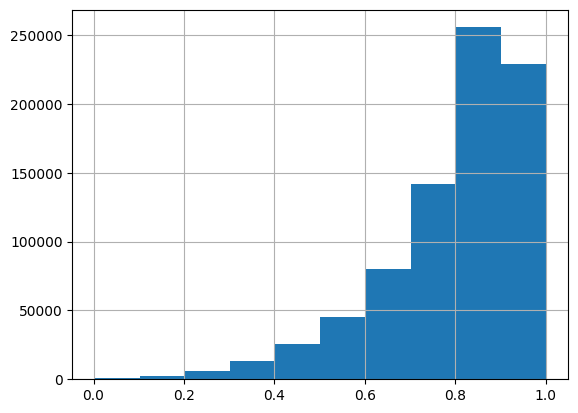

In [23]:
pred_df['__r1'].hist()

<AxesSubplot: >

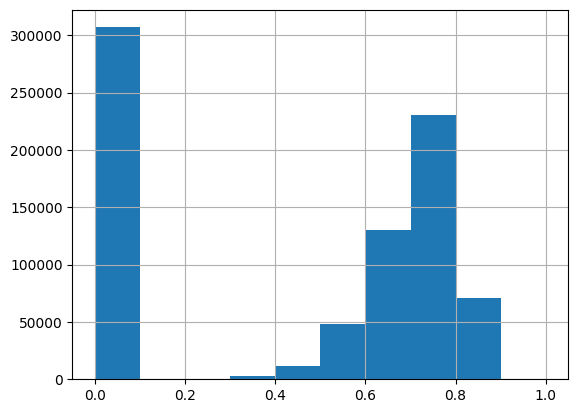

In [24]:
pred_df['baseline'].hist()

<AxesSubplot: >

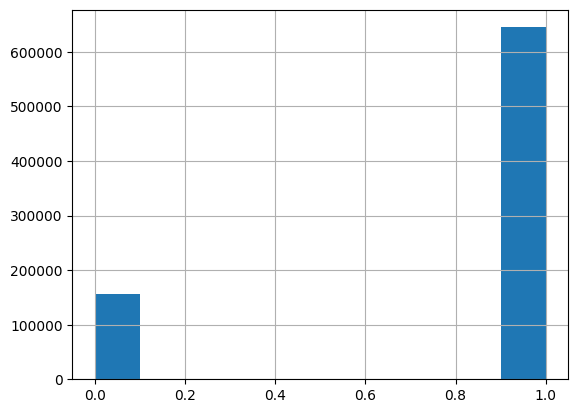

In [25]:
pred_df['relevance'].hist()

<AxesSubplot: >

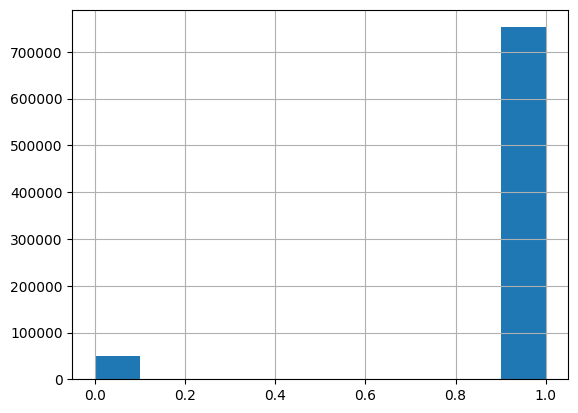

In [26]:
pred_df['response_bin'].hist()

In [27]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score
print(f"Regression ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")
print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")

Regression ROC AUC: 0.7346985280341717
ROC AUC (baseline): 0.5826515528795148


In [29]:
print(f"Regression Precision: {precision_score(pred_df.relevance, pred_df.response_bin)}")

print(f"Regression Recall: {recall_score(pred_df.relevance, pred_df.response_bin)}")

Regression Precision: 0.8292773023041977
Regression Recall: 0.9675848981718056


In [30]:
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")

print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")

Precision (baseline): 0.8167132708191279
Recall (baseline): 0.6072358792449086


# Обучение случайного леса

In [31]:
rf = RandomForestClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__rf_prob'
)

In [32]:
vee = VectorElementExtractor(inputCol='__rf_prob', outputCol='__r1', index=1)
pipeline = Pipeline(
    stages=[
        va,
        rf,
        vee
    ]
)

# Качество случайного леса

In [33]:
%%time
ber_rf_model = pipeline.fit(train_df)

CPU times: user 127 ms, sys: 33.7 ms, total: 161 ms
Wall time: 41.8 s


In [34]:
%%time
pred_df = ber_rf_model.transform(test_df).select("relevance", "__r1", "item_rating_avg").toPandas()

CPU times: user 4.04 s, sys: 157 ms, total: 4.2 s
Wall time: 19.8 s


In [35]:
pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
pred_df['response_bin'] = np.where(pred_df['__r1'] > 0.5, 1, 0) 

<AxesSubplot: >

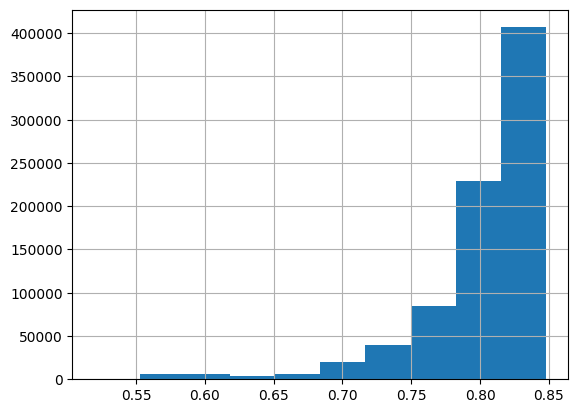

In [36]:
pred_df['__r1'].hist()

In [37]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score

print(f"Random Forest ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")
print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")

Random Forest ROC AUC: 0.7025193652352393
ROC AUC (baseline): 0.5826515528795148


In [38]:
print(f"Random Forest Precision: {precision_score(pred_df.relevance, pred_df.response_bin)}")

print(f"Random Forest Recall: {recall_score(pred_df.relevance, pred_df.response_bin)}")

Random Forest Precision: 0.8047340231086801
Random Forest Recall: 1.0


In [39]:
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")

print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")

Precision (baseline): 0.8167132708191279
Recall (baseline): 0.6072358792449086


# Обучение матричной факторизации

In [40]:
fm = FMClassifier(
    featuresCol='features',
    labelCol='relevance',
    probabilityCol='__fm_prob'
)

In [41]:
vee = VectorElementExtractor(inputCol='__fm_prob', outputCol='__r1', index=1)
pipeline = Pipeline(
    stages=[
        va,
        fm,
        vee
    ]
)

# Качество матричной факторизации

In [42]:
%%time
ber_fm_model = pipeline.fit(train_df)

CPU times: user 1.25 s, sys: 230 ms, total: 1.48 s
Wall time: 20min 9s


In [44]:
%%time
pred_df = ber_fm_model.transform(test_df).select("user_id", "item_id", "relevance", "__r1", "item_rating_avg").toPandas()

CPU times: user 3.85 s, sys: 449 ms, total: 4.3 s
Wall time: 29.2 s


In [45]:
pred_df['baseline'] = (pred_df['item_rating_avg']-pred_df['item_rating_avg'].min())/(pred_df['item_rating_avg'].max()-pred_df['item_rating_avg'].min())
pred_df['baseline_bin'] = np.where(pred_df['baseline'] > 0.5, 1, 0) 
pred_df['response_bin'] = np.where(pred_df['__r1'] > 0.5, 1, 0) 

<AxesSubplot: >

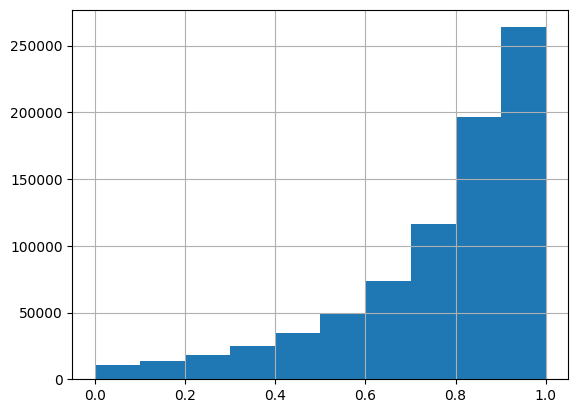

In [46]:
pred_df['__r1'].hist()

In [47]:
print(f"Factorization Machines ROC AUC: {roc_auc_score(pred_df.relevance, pred_df.__r1)}")
print(f"ROC AUC (baseline): {roc_auc_score(pred_df.relevance, pred_df.baseline)}")

Factorization Machines ROC AUC: 0.6826945781084109
ROC AUC (baseline): 0.5826515528795148


In [48]:
print(f"Factorization Machines Precision: {precision_score(pred_df.relevance, pred_df.response_bin)}")

print(f"Factorization Machines Recall: {recall_score(pred_df.relevance, pred_df.response_bin)}")

Factorization Machines Precision: 0.8410031500225001
Factorization Machines Recall: 0.9126987572247166


In [49]:
print(f"Precision (baseline): {precision_score(pred_df.relevance, pred_df.baseline_bin)}")

print(f"Recall (baseline): {recall_score(pred_df.relevance, pred_df.baseline_bin)}")

Precision (baseline): 0.8167132708191279
Recall (baseline): 0.6072358792449086


Оказалось, что логистическая регрессия дает лучшее качество с точки зрения ROC-AUC и Precision по сравнению с двумя другими моделями. Кроме того, она обучается заметно быстрее, чем матричная факторизация.

# Обучение рексистемы

Далее будем в цикле обучать рекомендательную систему на откликах синтетических пользователей, полученных с помощью симулятора.

In [85]:
%%time
lr_model = lr.fit(va.transform(train_df))
pipeline = PipelineModel(
    stages=[
        va,
        lr_model,
        vee,
        mc,
        br
    ]
)

CPU times: user 34.1 ms, sys: 8.25 ms, total: 42.4 ms
Wall time: 45 s


In [112]:
%%time
indexer = Indexer(user_col='user_id', item_col='item_id')
indexer.fit(users=generator_1.sample(1.0), items=items_df_test)

model = UCB(sample = True)

## Предположим, что модель уже обучена на реальных данных
model.fit(log=indexer.transform(log_df_val.drop('response').limit(1)))

22/10/12 12:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/12 12:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB


CPU times: user 415 ms, sys: 100 ms, total: 515 ms
Wall time: 3.18 s


22/10/12 12:24:37 WARN DAGScheduler: Broadcasting large task binary with size 1016.3 KiB


В качестве бейзлайна будем использовать рекомендательную систему, которая предлагает пользователю случайные предложения.

In [113]:
%%time
random_uni = RandomRec(distribution="uniform")
random_uni.fit(log=indexer.transform(log_df_val.drop('response').limit(1)))

22/10/12 12:24:39 WARN DAGScheduler: Broadcasting large task binary with size 1004.6 KiB
22/10/12 12:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1006.3 KiB


CPU times: user 86 ms, sys: 8.59 ms, total: 94.6 ms
Wall time: 1.12 s


22/10/12 12:24:40 WARN DAGScheduler: Broadcasting large task binary with size 1012.7 KiB


In [114]:
%%time
item_estimator = CrossJoinItemEstimator(
    k=1000,
    userKeyColumn='user_id',
    itemKeyColumn='item_id',
    seed=1234
)
selector = item_estimator.fit(items_df_test)

CPU times: user 746 µs, sys: 0 ns, total: 746 µs
Wall time: 717 µs


In [115]:
evaluator = EvaluateMetrics(
    userKeyCol='user_id',
    itemKeyCol='item_id',
    predictionCol='relevance',
    labelCol='response',
    replay_label_filter=1.0,
    replay_metrics={NDCG() : 10, Precision() : 10, RocAuc(): 10}
)

In [116]:
%%time
LOG_SCHEMA = st.StructType([
    st.StructField('user_idx', st.IntegerType()),
    st.StructField('item_idx', st.IntegerType()),
    st.StructField('relevance', st.DoubleType()),
    st.StructField('timestamp', st.IntegerType())
])

metrics = []
baseline_metrics = []

rec_items = []
rec_items_b = []

K=10
for i in range(100):
    print(f'------------------------Stage {i}------------------------')
    start_iter = time.time()

    ## получаем пачку юзеров
    users = sim.sample_users(1.0).cache()

    ## для этих юзеров получаем кусок лога (при наличии)
    log = sim.get_log(user_df=users)
    
    if log is not None:
        log = log.select('user_id', 'item_id').cache()
    
    item_ids = indexer.transform(items_df_test.select("item_id").sample(0.2)).cache()
    recs = model.predict(
                   indexer.transform(log) if log is not None else None, 
                   10,
                   indexer.transform(users.select("user_id")),
                   item_ids,
                   filter_seen_items = False
        )
    recs = indexer.inverse_transform(recs).cache()
    rec_items.append(recs.toPandas())
    
    if log is not None:
        log = indexer.transform(log)
    else:
        log = spark.createDataFrame(
            data=spark.sparkContext.emptyRDD(),
            schema=LOG_SCHEMA
        )
        
    baseline_recs = random_uni.predict(
                                log,
                                10,
                                indexer.transform(users.select("user_id")),
                                item_ids,
                                filter_seen_items = False
        )
    baseline_recs = indexer.inverse_transform(baseline_recs).cache()
    rec_items_b.append(baseline_recs.toPandas())
    
    ## симулируем действия пользователя
    true_resp = sim.sample_responses(
        recs_df=recs,
        user_features=users,
        item_features=items_df_test,
        action_models=pipeline
    ).select('user_id', 'item_id', 'relevance', 'response').cache()
    
    baseline_true_resp = sim.sample_responses(
        recs_df=baseline_recs,
        user_features=users,
        item_features=items_df_test,
        action_models=pipeline
    )\
    .select('user_id', 'item_id', 'relevance', 'response')
    baseline_true_resp.cache()

    ## сохраняем лог
    sim.update_log(true_resp, iteration=i)

    metrics.append(evaluator(true_resp))
    baseline_metrics.append(evaluator(baseline_true_resp))

    ## обновляем веса
    model._clear_cache()
    train_log = sim.log.cache()
    model.fit(
        log=indexer.transform(
            train_log.select('user_id', 'item_id', 'response')\
                     .withColumnRenamed('response', 'relevance')
        )
    )
    
    random_uni._clear_cache()
    random_uni.fit(
        log=indexer.transform(
            baseline_true_resp.select('user_id', 'item_id', 'response')\
                        .withColumnRenamed('response', 'relevance')\
                        .filter(sf.col('relevance') == 1)
        )
    )

    ## удаляем лишний кеш
    users.unpersist()
    if log is not None:
        log.unpersist()
    recs.unpersist()
    baseline_recs.unpersist()
    true_resp.unpersist()
    baseline_true_resp.unpersist()
    train_log.unpersist()
    
    end_iter = time.time()
    print(f"Time of {i+1} iteration: ")
    print(end_iter - start_iter)

------------------------Stage 0------------------------


22/10/12 12:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:24:54 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/12 12:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:24:55 WARN DAGScheduler: Broadcasting large task binary with size 1174.1 KiB
22/10/12 12:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1016.4 KiB
22/10/12 12:24:56 WARN DAGScheduler: Broadcasting large task binary with size 1172.8 KiB
22/10/12 12:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1010.4 KiB
22/10/12 12:25:03 WAR

Time of 1 iteration: 
43.81062602996826
------------------------Stage 1------------------------


22/10/12 12:25:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:25:39 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:25:40 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:25:46 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:25:48 WARN DAGScheduler: Broadcasting large task binary with size 1951.8 KiB
22/10/12 12:25:50 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:25:50 WAR

Time of 2 iteration: 
47.36297821998596
------------------------Stage 2------------------------


22/10/12 12:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:26:26 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:26:27 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:26:28 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:26:34 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:26:38 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:26:38 WAR

Time of 3 iteration: 
46.149880170822144
------------------------Stage 3------------------------


22/10/12 12:27:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:27:13 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:27:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:27:15 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:27:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:27:22 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:27:24 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 12:27:26 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:27:26 WAR

Time of 4 iteration: 
50.694804191589355
------------------------Stage 4------------------------


22/10/12 12:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:04 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:11 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:28:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:13 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 12:28:15 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:28:15 WAR

Time of 5 iteration: 
49.28304100036621
------------------------Stage 5------------------------


22/10/12 12:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:54 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:55 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:28:56 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 12:29:07 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:29:07 WAR

Time of 6 iteration: 
49.962464332580566
------------------------Stage 6------------------------


22/10/12 12:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:43 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:44 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:45 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:29:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:52 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:29:53 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 12:29:55 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:29:56 WAR

Time of 7 iteration: 
47.617162227630615
------------------------Stage 7------------------------


22/10/12 12:30:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:30:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:30:32 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:30:39 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:30:41 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 12:30:43 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:30:43 WAR

Time of 8 iteration: 
48.42216730117798
------------------------Stage 8------------------------


22/10/12 12:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:31:32 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:31:33 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:31:34 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 12:31:46 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:31:46 WAR

Time of 9 iteration: 
65.16773962974548
------------------------Stage 9------------------------


22/10/12 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:32:25 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:32:26 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:32:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:32:27 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:32:35 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:32:37 WARN DAGScheduler: Broadcasting large task binary with size 1959.9 KiB
22/10/12 12:32:39 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:32:40 WAR

Time of 10 iteration: 
54.90097236633301
------------------------Stage 10------------------------


22/10/12 12:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:33:21 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:33:22 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:33:23 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:33:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:33:32 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:33:34 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:33:35 WAR

Time of 11 iteration: 
52.66160345077515
------------------------Stage 11------------------------


22/10/12 12:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:34:13 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:34:14 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:34:23 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:34:24 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 12:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:34:27 WAR

Time of 12 iteration: 
51.251376152038574
------------------------Stage 12------------------------


22/10/12 12:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:04 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:05 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:06 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:14 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:15 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 12:35:17 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:35:18 WAR

Time of 13 iteration: 
51.43056654930115
------------------------Stage 13------------------------


22/10/12 12:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:36:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:36:07 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:36:08 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 12:36:10 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:36:11 WAR

Time of 14 iteration: 
53.29951500892639
------------------------Stage 14------------------------


22/10/12 12:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:36:50 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:36:51 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:37:00 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:37:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:37:02 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:37:04 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:37:04 WAR

Time of 15 iteration: 
53.961331367492676
------------------------Stage 15------------------------


22/10/12 12:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:37:44 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:37:45 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:38:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:38:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:38:04 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 12:38:06 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:38:07 WAR

Time of 16 iteration: 
68.98010683059692
------------------------Stage 16------------------------


22/10/12 12:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:38:53 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:38:54 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:38:55 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:39:04 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:39:06 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:39:08 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:39:09 WAR

Time of 17 iteration: 
57.746047019958496
------------------------Stage 17------------------------


22/10/12 12:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:39:51 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:39:52 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:40:02 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:40:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:40:03 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
22/10/12 12:40:05 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:40:06 WAR

Time of 18 iteration: 
56.61820888519287
------------------------Stage 18------------------------


22/10/12 12:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:40:50 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:40:51 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:41:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:41:01 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:41:05 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:41:05 WAR

Time of 19 iteration: 
60.72016954421997
------------------------Stage 19------------------------


22/10/12 12:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:41:49 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:41:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:41:50 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:41:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:41:51 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:42:02 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:42:04 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:42:04 WAR

Time of 20 iteration: 
60.8895103931427
------------------------Stage 20------------------------


22/10/12 12:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:42:50 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:42:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:42:51 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:42:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:42:52 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:43:02 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:43:03 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 12:43:05 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:43:06 WAR

Time of 21 iteration: 
60.13811731338501
------------------------Stage 21------------------------


22/10/12 12:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:43:50 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:43:51 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:43:52 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:44:02 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:44:04 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:44:06 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:44:07 WAR

Time of 22 iteration: 
65.35476756095886
------------------------Stage 22------------------------


22/10/12 12:44:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:44:56 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:44:57 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:44:58 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:45:08 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:45:10 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 12:45:12 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:45:13 WAR

Time of 23 iteration: 
62.289653062820435
------------------------Stage 23------------------------


22/10/12 12:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:45:59 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:46:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:46:11 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:46:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:46:13 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 12:46:15 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:46:16 WAR

Time of 24 iteration: 
64.81204652786255
------------------------Stage 24------------------------


22/10/12 12:47:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:47:04 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:47:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:47:16 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:47:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:47:18 WARN DAGScheduler: Broadcasting large task binary with size 1959.9 KiB
22/10/12 12:47:20 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:47:21 WAR

Time of 25 iteration: 
65.94382691383362
------------------------Stage 25------------------------


22/10/12 12:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:48:10 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:48:11 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:48:12 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:48:23 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:48:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:48:25 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 12:48:27 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:48:28 WAR

Time of 26 iteration: 
65.69095730781555
------------------------Stage 26------------------------


22/10/12 12:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:49:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:49:16 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:49:17 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:49:28 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:49:30 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 12:49:33 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:49:33 WAR

Time of 27 iteration: 
68.17561960220337
------------------------Stage 27------------------------


22/10/12 12:50:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:50:24 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:50:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:50:26 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:50:38 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:50:39 WARN DAGScheduler: Broadcasting large task binary with size 1959.8 KiB
22/10/12 12:50:41 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:50:42 WAR

Time of 28 iteration: 
68.74724411964417
------------------------Stage 28------------------------


22/10/12 12:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:51:33 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:51:34 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:51:35 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:51:47 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:51:48 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 12:51:50 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:51:51 WAR

Time of 29 iteration: 
65.78790473937988
------------------------Stage 29------------------------


22/10/12 12:52:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:52:39 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:52:40 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:52:41 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:52:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:52:55 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 12:52:57 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:52:58 WAR

Time of 30 iteration: 
66.2434024810791
------------------------Stage 30------------------------


22/10/12 12:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:53:45 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:53:46 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:53:47 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:53:58 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:54:00 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
22/10/12 12:54:02 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:54:03 WAR

Time of 31 iteration: 
66.86199760437012
------------------------Stage 31------------------------


22/10/12 12:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:54:52 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:54:54 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:55:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:55:06 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:55:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:55:08 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 12:55:10 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:55:11 WAR

Time of 32 iteration: 
67.94556474685669
------------------------Stage 32------------------------


22/10/12 12:56:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:56:01 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:56:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:56:02 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:56:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:56:03 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:56:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:56:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:56:17 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 12:56:19 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:56:20 WAR

Time of 33 iteration: 
71.36805367469788
------------------------Stage 33------------------------


22/10/12 12:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:57:12 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:57:13 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:57:14 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:57:28 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:57:29 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 12:57:31 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:57:33 WAR

Time of 34 iteration: 
72.18400621414185
------------------------Stage 34------------------------


22/10/12 12:58:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:58:25 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:58:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:58:26 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:58:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:58:27 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:58:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:58:40 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:58:42 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:58:42 WARN DAGScheduler: Broadcasting large task binary with size 1959.7 KiB
22/10/12 12:58:44 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 12:58:45 WAR

Time of 35 iteration: 
73.60625529289246
------------------------Stage 35------------------------


22/10/12 12:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:59:39 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 12:59:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:59:41 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 12:59:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:59:54 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 12:59:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 12:59:56 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 12:59:58 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:00:00 WAR

Time of 36 iteration: 
73.92903804779053
------------------------Stage 36------------------------


22/10/12 13:00:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:00:52 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:00:54 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:01:07 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:01:08 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 13:01:11 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:01:12 WAR

Time of 37 iteration: 
85.5426504611969
------------------------Stage 37------------------------


22/10/12 13:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:02:19 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:02:20 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:02:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:02:21 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:02:34 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 13:02:37 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:02:38 WAR

Time of 38 iteration: 
73.24408173561096
------------------------Stage 38------------------------


22/10/12 13:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:03:32 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:03:33 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:03:34 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:03:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:03:47 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:03:49 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 13:03:51 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:03:52 WAR

Time of 39 iteration: 
73.53122782707214
------------------------Stage 39------------------------


22/10/12 13:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:04:46 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:04:47 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:05:02 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:05:03 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 13:05:05 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:05:07 WAR

Time of 40 iteration: 
77.04353642463684
------------------------Stage 40------------------------


22/10/12 13:06:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:06:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:06:04 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:06:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:06:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:06:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:06:21 WARN DAGScheduler: Broadcasting large task binary with size 1960.7 KiB
22/10/12 13:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:06:24 WAR

Time of 41 iteration: 
76.46112322807312
------------------------Stage 41------------------------


22/10/12 13:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:07:19 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:07:20 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:07:22 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:07:35 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:07:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:07:37 WARN DAGScheduler: Broadcasting large task binary with size 1959.5 KiB
22/10/12 13:07:39 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:07:40 WAR

Time of 42 iteration: 
76.20285844802856
------------------------Stage 42------------------------


22/10/12 13:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:08:36 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:08:37 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:08:38 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:08:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:08:53 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:08:54 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 13:08:56 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:08:58 WAR

Time of 43 iteration: 
79.20320105552673
------------------------Stage 43------------------------


22/10/12 13:09:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:09:55 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:09:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:09:56 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:09:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:09:57 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:10:10 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:10:10 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:10:12 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 13:10:15 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:10:15 WAR

Time of 44 iteration: 
76.67329025268555
------------------------Stage 44------------------------


22/10/12 13:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:11:12 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:11:13 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:11:14 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:11:30 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:11:32 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:11:33 WAR

Time of 45 iteration: 
78.62875604629517
------------------------Stage 45------------------------


22/10/12 13:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:12:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:12:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:12:33 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:12:48 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:12:50 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:12:52 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:12:53 WAR

Time of 46 iteration: 
79.3401107788086
------------------------Stage 46------------------------


22/10/12 13:13:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:13:52 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:13:53 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:14:09 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:14:09 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:14:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:14:11 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 13:14:13 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:14:14 WAR

Time of 47 iteration: 
82.68920636177063
------------------------Stage 47------------------------


22/10/12 13:15:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:15:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:15:16 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:15:17 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:15:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:15:32 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:15:34 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 13:15:36 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:15:37 WAR

Time of 48 iteration: 
81.90533351898193
------------------------Stage 48------------------------


22/10/12 13:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:16:36 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:16:37 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:16:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:16:38 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:16:54 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:16:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:16:56 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:16:59 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:16:59 WAR

Time of 49 iteration: 
83.30154705047607
------------------------Stage 49------------------------


22/10/12 13:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:18:00 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:18:01 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:18:02 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:18:18 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:18:19 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:18:22 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:18:23 WAR

Time of 50 iteration: 
83.73217988014221
------------------------Stage 50------------------------


22/10/12 13:19:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:19:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:19:25 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:19:41 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:19:41 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:19:44 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 13:19:46 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:19:47 WAR

Time of 51 iteration: 
84.28483152389526
------------------------Stage 51------------------------


22/10/12 13:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:20:49 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:20:50 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:20:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:20:51 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:21:07 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:21:09 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 13:21:11 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:21:13 WAR

Time of 52 iteration: 
85.19333481788635
------------------------Stage 52------------------------


22/10/12 13:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:22:13 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:22:14 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:22:15 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:22:32 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:22:34 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 13:22:36 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:22:37 WAR

Time of 53 iteration: 
84.62455606460571
------------------------Stage 53------------------------


22/10/12 13:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:23:39 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:23:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:23:40 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:23:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:23:41 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:23:57 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:23:59 WARN DAGScheduler: Broadcasting large task binary with size 1959.9 KiB
22/10/12 13:24:02 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:24:03 WAR

Time of 54 iteration: 
88.30326342582703
------------------------Stage 54------------------------


22/10/12 13:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:25:07 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:25:08 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:25:09 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:25:26 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 13:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:25:31 WAR

Time of 55 iteration: 
86.4141492843628
------------------------Stage 55------------------------


22/10/12 13:26:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:26:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:26:37 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:26:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:26:56 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:26:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:26:57 WARN DAGScheduler: Broadcasting large task binary with size 1961.0 KiB
22/10/12 13:26:59 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:27:02 WAR

Time of 56 iteration: 
91.72865295410156
------------------------Stage 56------------------------


22/10/12 13:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:28:07 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:28:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:28:09 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:28:27 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:28:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:28:28 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 13:28:30 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:28:32 WAR

Time of 57 iteration: 
90.72969079017639
------------------------Stage 57------------------------


22/10/12 13:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:29:37 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:29:38 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:29:39 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:29:57 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:29:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:29:59 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:30:01 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:30:03 WAR

Time of 58 iteration: 
93.7084629535675
------------------------Stage 58------------------------


22/10/12 13:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:31:11 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:31:12 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:31:13 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:31:42 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:31:43 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:31:44 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:31:45 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 13:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:31:49 WAR

Time of 59 iteration: 
104.07762837409973
------------------------Stage 59------------------------


22/10/12 13:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:32:55 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:32:56 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:32:57 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:33:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:33:17 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
22/10/12 13:33:19 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:33:22 WAR

Time of 60 iteration: 
91.45798087120056
------------------------Stage 60------------------------


22/10/12 13:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:34:25 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:34:27 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:34:28 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:34:47 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:34:49 WARN DAGScheduler: Broadcasting large task binary with size 1959.8 KiB
22/10/12 13:34:51 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:34:53 WAR

Time of 61 iteration: 
90.87102007865906
------------------------Stage 61------------------------


22/10/12 13:35:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:35:58 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:35:59 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:36:00 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:36:19 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:36:20 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:36:21 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 13:36:23 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:36:24 WAR

Time of 62 iteration: 
91.77145147323608
------------------------Stage 62------------------------


22/10/12 13:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:37:29 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:37:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:37:32 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:37:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:37:51 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:37:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:37:53 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 13:37:55 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:37:57 WAR

Time of 63 iteration: 
93.29750919342041
------------------------Stage 63------------------------


22/10/12 13:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:39:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:39:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:39:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:39:26 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:39:27 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 13:39:29 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:39:31 WAR

Time of 64 iteration: 
94.12114381790161
------------------------Stage 64------------------------


22/10/12 13:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:40:37 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:40:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:40:38 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:40:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:40:39 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:40:57 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:40:58 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:40:59 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 13:41:02 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:41:03 WAR

Time of 65 iteration: 
93.34399604797363
------------------------Stage 65------------------------


22/10/12 13:42:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:42:11 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:42:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:42:12 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:42:13 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:42:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:42:33 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:42:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:42:35 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:42:37 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:42:38 WAR

Time of 66 iteration: 
95.90199446678162
------------------------Stage 66------------------------


22/10/12 13:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:43:48 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:43:49 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:44:10 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:44:10 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:44:13 WARN DAGScheduler: Broadcasting large task binary with size 1960.7 KiB
22/10/12 13:44:15 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:44:17 WAR

Time of 67 iteration: 
102.36975502967834
------------------------Stage 67------------------------


22/10/12 13:45:35 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:45:35 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:45:36 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:45:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:45:58 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:46:00 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:46:02 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:46:05 WAR

Time of 68 iteration: 
116.57795906066895
------------------------Stage 68------------------------


22/10/12 13:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:47:30 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:47:31 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:47:54 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:47:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:47:56 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 13:47:58 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:48:01 WAR

Time of 69 iteration: 
111.14517426490784
------------------------Stage 69------------------------


22/10/12 13:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:49:20 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:49:21 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:49:43 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:49:43 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:49:45 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 13:49:47 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:49:49 WAR

Time of 70 iteration: 
103.87685298919678
------------------------Stage 70------------------------


22/10/12 13:51:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:51:04 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:51:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:51:05 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:51:06 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:51:28 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:51:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:51:30 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 13:51:32 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:51:34 WAR

Time of 71 iteration: 
107.48750424385071
------------------------Stage 71------------------------


22/10/12 13:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:52:52 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:52:53 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:52:54 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:52:54 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:53:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:53:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:53:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:53:17 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 13:53:19 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:53:21 WAR

Time of 72 iteration: 
105.16783738136292
------------------------Stage 72------------------------


22/10/12 13:54:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:54:37 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:54:38 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:54:39 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:55:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:55:00 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:55:02 WARN DAGScheduler: Broadcasting large task binary with size 1959.9 KiB
22/10/12 13:55:04 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:55:06 WAR

Time of 73 iteration: 
104.69216561317444
------------------------Stage 73------------------------


22/10/12 13:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:56:23 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:56:24 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:56:48 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:56:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:56:51 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 13:56:53 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:56:55 WAR

Time of 74 iteration: 
109.52725553512573
------------------------Stage 74------------------------


22/10/12 13:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:58:12 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 13:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:58:13 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 13:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:58:34 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 13:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:58:36 WARN DAGScheduler: Broadcasting large task binary with size 1959.6 KiB
22/10/12 13:58:39 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 13:58:40 WAR

Time of 75 iteration: 
107.7500171661377
------------------------Stage 75------------------------


22/10/12 13:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 13:59:59 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:00:00 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:00:01 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:00:22 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:00:25 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 14:00:27 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:00:29 WAR

Time of 76 iteration: 
122.73488664627075
------------------------Stage 76------------------------


22/10/12 14:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:02:04 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:02:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:02:06 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:02:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:02:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:02:33 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 14:02:35 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:02:37 WAR

Time of 77 iteration: 
115.06194424629211
------------------------Stage 77------------------------


22/10/12 14:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:03:58 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:03:59 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:04:22 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:04:24 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 14:04:26 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:04:28 WAR

Time of 78 iteration: 
109.28612852096558
------------------------Stage 78------------------------


22/10/12 14:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:05:50 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:05:51 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:05:52 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:06:18 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:06:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:06:20 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 14:06:23 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:06:25 WAR

Time of 79 iteration: 
117.48045229911804
------------------------Stage 79------------------------


22/10/12 14:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:07:46 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:07:47 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:08:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:08:12 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:08:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:08:13 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 14:08:16 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:08:18 WAR

Time of 80 iteration: 
112.63396096229553
------------------------Stage 80------------------------


22/10/12 14:09:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:09:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:09:39 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:10:01 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:10:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:10:04 WARN DAGScheduler: Broadcasting large task binary with size 1960.4 KiB
22/10/12 14:10:06 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:10:08 WAR

Time of 81 iteration: 
110.08373785018921
------------------------Stage 81------------------------


22/10/12 14:11:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:11:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:11:29 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:11:53 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:11:55 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 14:11:57 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:11:59 WAR

Time of 82 iteration: 
111.0680296421051
------------------------Stage 82------------------------


22/10/12 14:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:13:19 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:13:21 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:13:45 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:13:46 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:13:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:13:47 WARN DAGScheduler: Broadcasting large task binary with size 1960.6 KiB
22/10/12 14:13:49 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:13:52 WAR

Time of 83 iteration: 
112.45969128608704
------------------------Stage 83------------------------


22/10/12 14:15:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:15:11 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:15:12 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:15:12 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:15:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:15:13 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:15:37 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:15:38 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 14:15:40 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:15:42 WAR

Time of 84 iteration: 
111.14975190162659
------------------------Stage 84------------------------


22/10/12 14:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:17:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:17:05 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:17:06 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:17:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:17:32 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 14:17:34 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:17:36 WAR

Time of 85 iteration: 
117.69505071640015
------------------------Stage 85------------------------


22/10/12 14:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:19:02 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:19:03 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:19:04 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:19:29 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:19:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:19:31 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 14:19:33 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:19:35 WAR

Time of 86 iteration: 
117.02658987045288
------------------------Stage 86------------------------


22/10/12 14:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:20:59 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:21:00 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:21:01 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:21:24 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:21:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:21:27 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 14:21:29 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:21:31 WAR

Time of 87 iteration: 
114.7913007736206
------------------------Stage 87------------------------


22/10/12 14:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:22:55 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:22:56 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:23:22 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:23:23 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:23:25 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:23:25 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 14:23:27 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:23:30 WAR

Time of 88 iteration: 
123.69332337379456
------------------------Stage 88------------------------


22/10/12 14:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:25:01 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:25:02 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:25:03 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:25:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:25:28 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:25:30 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 14:25:32 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:25:35 WAR

Time of 89 iteration: 
123.40583419799805
------------------------Stage 89------------------------


22/10/12 14:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:27:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:27:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:27:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:27:29 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:27:32 WARN DAGScheduler: Broadcasting large task binary with size 1959.8 KiB
22/10/12 14:27:34 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:27:36 WAR

Time of 90 iteration: 
120.67250657081604
------------------------Stage 90------------------------


22/10/12 14:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:29:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:29:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:29:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:29:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:29:32 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 14:29:34 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:29:37 WAR

Time of 91 iteration: 
120.80466747283936
------------------------Stage 91------------------------


22/10/12 14:31:02 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:31:03 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:31:04 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:31:05 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:31:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:31:48 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:31:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:31:50 WARN DAGScheduler: Broadcasting large task binary with size 1959.9 KiB
22/10/12 14:31:52 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:31:54 WAR

Time of 92 iteration: 
139.60197162628174
------------------------Stage 92------------------------


22/10/12 14:33:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:33:26 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:33:27 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:33:28 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:33:55 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:33:56 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:33:56 WARN DAGScheduler: Broadcasting large task binary with size 1960.5 KiB
22/10/12 14:33:59 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:34:01 WAR

Time of 93 iteration: 
125.28953647613525
------------------------Stage 93------------------------


22/10/12 14:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:35:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:35:32 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:35:33 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:36:01 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:36:03 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:36:03 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 14:36:05 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:36:07 WAR

Time of 94 iteration: 
131.9413139820099
------------------------Stage 94------------------------


22/10/12 14:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:37:40 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:37:41 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:37:43 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:38:11 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:38:13 WARN DAGScheduler: Broadcasting large task binary with size 1960.2 KiB
22/10/12 14:38:15 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:38:18 WAR

Time of 95 iteration: 
124.61744499206543
------------------------Stage 95------------------------


22/10/12 14:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:39:46 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:39:47 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:39:48 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:39:48 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:40:15 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:40:18 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 14:40:20 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:40:22 WAR

Time of 96 iteration: 
129.7407968044281
------------------------Stage 96------------------------


22/10/12 14:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:41:58 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:41:59 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:42:00 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:42:26 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:42:26 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:42:29 WARN DAGScheduler: Broadcasting large task binary with size 1960.1 KiB
22/10/12 14:42:31 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:42:34 WAR

Time of 97 iteration: 
128.52753710746765
------------------------Stage 97------------------------


22/10/12 14:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:44:05 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:44:08 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:44:08 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:44:09 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:44:38 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:44:40 WARN DAGScheduler: Broadcasting large task binary with size 1960.0 KiB
22/10/12 14:44:43 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:44:45 WAR

Time of 98 iteration: 
133.59048628807068
------------------------Stage 98------------------------


22/10/12 14:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:46:17 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:46:19 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:46:20 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:46:47 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:46:49 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:46:50 WARN DAGScheduler: Broadcasting large task binary with size 1960.8 KiB
22/10/12 14:46:52 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:46:54 WAR

Time of 99 iteration: 
128.20652270317078
------------------------Stage 99------------------------


22/10/12 14:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:48:31 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1119.2 KiB
22/10/12 14:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:48:32 WARN DAGScheduler: Broadcasting large task binary with size 1117.8 KiB
22/10/12 14:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:49:06 WARN DAGScheduler: Broadcasting large task binary with size 1078.8 KiB
22/10/12 14:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1074.2 KiB
22/10/12 14:49:09 WARN DAGScheduler: Broadcasting large task binary with size 1960.3 KiB
22/10/12 14:49:11 WARN DAGScheduler: Broadcasting large task binary with size 1281.7 KiB
22/10/12 14:49:14 WAR

Time of 100 iteration: 
144.78192114830017
CPU times: user 17min, sys: 1min 55s, total: 18min 55s
Wall time: 2h 25min 32s


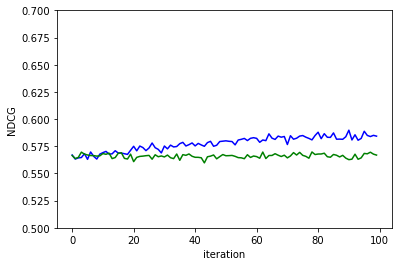

In [120]:
metrics_pdf = pd.DataFrame(metrics)
baseline_metrics_pdf = pd.DataFrame(baseline_metrics)

plt.plot(metrics_pdf['NDCG@10'], color='b')
plt.plot(baseline_metrics_pdf['NDCG@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('NDCG')
plt.ylim(0.5, 0.7)
plt.savefig('ml_ndcg_new_users_base.png', dpi=300)

(0.2, 0.25)

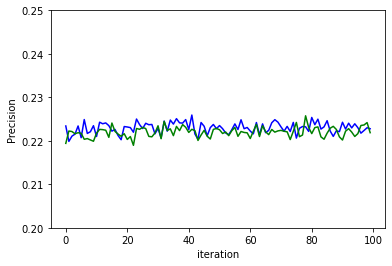

In [118]:
plt.plot(metrics_pdf['Precision@10'], color='b')
plt.plot(baseline_metrics_pdf['Precision@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('Precision')
plt.ylim(0.20, 0.25)
#plt.savefig('ml_precision_new_users_1.png', dpi=300)

(0.4, 0.6)

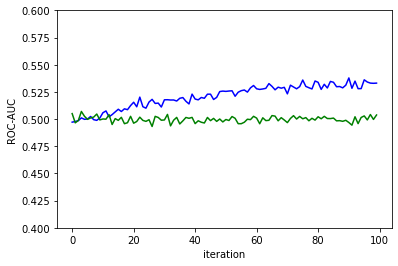

In [119]:
plt.plot(metrics_pdf['RocAuc@10'], color='b')
plt.plot(baseline_metrics_pdf['RocAuc@10'], color='g')
plt.xlabel('iteration')
plt.ylabel('ROC-AUC')
plt.ylim(0.4, 0.6)